Resources:

http://forums.fast.ai/t/fastai-for-image-captioning/17003/8

https://github.com/githubharald/SimpleHTR/blob/master/src/DataLoader.py

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.fastai.conv_learner import *
from fastai.fastai.text import *

In [4]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

In [5]:
!ls {PATH}

ascii             lines             tmp               words
forms             models            word_char_ids.csv words.csv
line_labels.csv   sentences         word_labels.csv


In [6]:
from PIL import Image

def open_image(fname):
    f = fname if fname.endswith('.png') else fname+'.png'
    return Image.open(f'{PATH}/words/{f}')

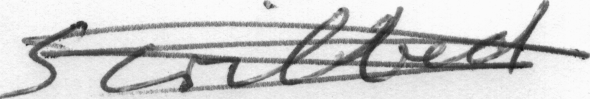

In [6]:
open_image('p06-047-08-00')

# Words

### DataFrame (manual)

In [7]:
# https://github.com/githubharald/SimpleHTR/blob/master/src/Model.py
    
imgSize = (128, 32)
maxTextLen = 32
samples = []
chars = set()

f=open(f'{PATH}/ascii/words.txt')
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    fileName = lineSplit[0]

    # GT text are columns starting at 9
    gtText = ''.join(lineSplit[8:])[:maxTextLen]
    chars = chars.union(set(list(gtText)))

    # put sample into list
    samples.append([fileName, gtText])

In [8]:
data = np.stack(samples)
data.shape

(115320, 2)

In [61]:
data[:,1]

array(['A', 'MOVE', 'to', ..., 'the', 'garden', '?'],
      dtype='<U32')

In [25]:
df = pd.DataFrame(data, columns=['filename', 'word'])
df.head()

,filename,word
0,a01-000u-00-00,A
1,a01-000u-00-01,MOVE
2,a01-000u-00-02,to
3,a01-000u-00-03,stop
4,a01-000u-00-04,Mr.


In [9]:
len(chars)

78

### DataFrame (read_csv)

In [10]:
word_labels = pd.read_csv(f'{PATH}/ascii/words.txt', delim_whitespace=True, comment="#", header=None, usecols=range(0, 9))

In [11]:
word_labels.columns = ['filename','result','graylevel','x','y','w','h','tag','value']

In [12]:
word_labels.tail()

,filename,result,graylevel,x,y,w,h,tag,value
75599,r06-143-04-06,ok,186,1323,1428,64,77,PP3O,him
75600,r06-143-04-07,ok,186,1458,1469,36,52,IN,in
75601,r06-143-04-08,ok,186,1532,1445,73,72,ATI,the
75602,r06-143-04-09,ok,186,1654,1444,199,114,NN,garden
75603,r06-143-04-10,ok,186,1892,1453,36,66,?,?


In [ ]:
samp = word_labels.sample(8)
info = {f'{PATH}words/{r.filename}.png': r.value for i,r in samp.iterrows()}

fnames = list(info.keys())
titles = list(info.values())

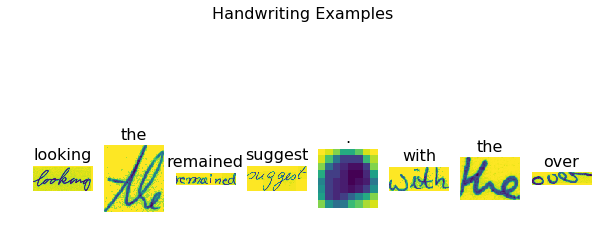

In [11]:
from fastai.fastai.plots import *

plots_from_files(fnames, titles=titles, maintitle="Handwriting Examples")

### check errors -> look OK

In [12]:
errors = word_labels[word_labels.result == 'err']

In [21]:
samp = errors.sample(8)
info = {f'{PATH}/words/{r.filename}.png': r.value for i,r in samp.iterrows()}

fnames = list(info.keys())
titles = list(info.values())

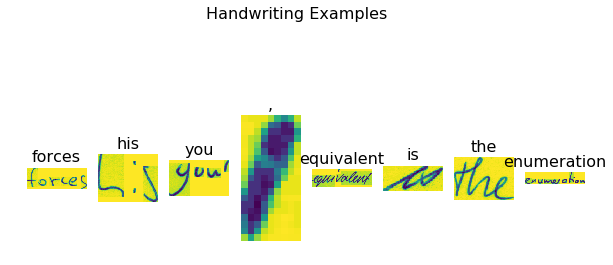

In [22]:
from fastai.fastai.plots import *

plots_from_files(fnames, titles=titles, maintitle="Handwriting Examples")

In [8]:
len(word_labels[word_labels.result == 'err']), len(word_labels)

(10847, 75604)

In [9]:
# remove all err results
# word_labels = word_labels[word_labels.result != 'err']
# len(word_labels)

64757

### Remove all rows where value count < 20 (word images)

In [27]:
# sort by label count
# pivot = word_labels.pivot_table(index='value', aggfunc=len).sort_values('filename', ascending=False)
pivot = df.pivot_table(index='word', aggfunc=len).sort_values('filename', ascending=False)

len(pivot)  # total num unique words

13547

In [28]:
# only keep values with counts > 20
pivot = pivot[pivot.filename > 20]
len(pivot)  # 406 unique words seen more than 20 times

568

In [29]:
value_mask = np.array(pivot.index)
value_mask

array(['the', ',', '.', 'of', 'to', 'and', 'a', 'in', '"', 'was', 'that', 'is', 'he', 'for', "'", 'with', 'I',
       'had', 'be', 'his', 'it', 'as', 'on', 'The', 'at', 'by', 'not', 'which', 'have', 'but', 'her', 'an',
       'from', 'are', 'been', 'you', 'this', 'Mr.', '-', 'has', 'He', 'were', 'It', 'will', 'they', 'or',
       'who', 'would', 'said', 'she', 'their', 'we', '?', 'all', 'him', '!', 'one', 'so', 'more', 'out', ';',
       'there', '(', ')', 'no', 'up', 'than', 'But', 'In', 'when', 'about', 'A', ':', 'them', 'may', 'being',
       'what', 'first', 'man', '...', 'into', 'if', 'can', 'could', 'time', 'only', 'me', 'other', 'some',
       'new', "'s", 'like', 'two', 'over', 'This', 'much', 'made', 'do', 'And', 'my', 'very', 'now', 'people',
       'its', 'these', 'any', 'You', 'well', 'told', 'We', 'before', 'our', 'then', 'even', 'must', 'back',
       'your', 'What', 'most', 'They', 'last', 'Sir', 'good', 'life', 'great', 'years', 'She', 'know',
       'There', 'Governmen

In [16]:
# apply value_mask to original csv
word_labels = word_labels[word_labels.value.isin(value_mask)]
len(word_labels)

49504

In [30]:
# apply value_mask to original csv
df = df[df.word.isin(value_mask)]
len(df)

79789

### Numericalize characters

In [17]:
itos = sorted(list(chars))
len(itos)

78

In [33]:
itos.insert(0, '_pad_')
itos.insert(1, '_bos_')
itos.insert(2, '_unk_')

stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([1]+[stoi[letter] for letter in word]) for word in df.word.values])

In [34]:
len(ids)

79789

In [35]:
# convert to strings (as labels)
strs = np.array([' '.join(str(l) for l in w) for w in ids])

In [39]:
len(ids), len(df), len(strs)

(79789, 79789, 79789)

In [45]:
df['chars'] = strs
df.tail()

,filename,word,chars
115314,r06-143-04-05,to,1 77 72
115315,r06-143-04-06,him,1 65 66 70
115316,r06-143-04-07,in,1 66 71
115317,r06-143-04-08,the,1 77 65 62
115319,r06-143-04-10,?,1 31


In [36]:
data = np.concatenate((data, z), axis=1)
data[:10]

array([['a01-000u-00-00', 'A', '1 29'],
       ['a01-000u-00-01', 'MOVE', '1 41 43 50 33'],
       ['a01-000u-00-02', 'to', '1 74 69'],
       ['a01-000u-00-03', 'stop', '1 73 74 69 70'],
       ['a01-000u-00-04', 'Mr.', '1 41 72 14'],
       ['a01-000u-00-05', 'Gaitskell', '1 35 55 63 74 73 65 59 66 66'],
       ['a01-000u-00-06', 'from', '1 60 72 69 67'],
       ['a01-000u-01-00', 'nominating', '1 68 69 67 63 68 55 74 63 68 61'],
       ['a01-000u-01-01', 'any', '1 55 68 79'],
       ['a01-000u-01-02', 'more', '1 67 69 72 59']],
      dtype='<U97')

In [37]:
# convert numpy array to dataframe
df = pd.DataFrame(data, columns=['filename', 'label', 'values'])
df.head()

,filename,label,values
0,a01-000u-00-00,A,1 29
1,a01-000u-00-01,MOVE,1 41 43 50 33
2,a01-000u-00-02,to,1 74 69
3,a01-000u-00-03,stop,1 73 74 69 70
4,a01-000u-00-04,Mr.,1 41 72 14


In [48]:
df.to_pickle(TMP_PATH/'words_and_chars.pkl')

In [ ]:
df = pd.read_pickle(TMP_PATH/'words_and_chars.pkl')
df.head()

In [49]:
np.save(TMP_PATH/'word_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'word_itos.pkl', 'wb'))

### Save to CSV

In [6]:
ids = np.load(TMP_PATH/'word_ids.npy')
itos = pickle.load(open(TMP_PATH/'word_itos.pkl', 'rb'))

In [ ]:
CSV = f'{PATH}/words.csv'

In [51]:
CSV = f'{PATH}/words.csv'
CHARS = f'{PATH}/words_chars.csv'

In [52]:
df.to_csv(CHARS, columns=['filename', 'chars'], index=False)
df.to_csv(CSV, columns=['filename', 'word'], index=False)

In [53]:
chars = pd.read_csv(CHARS)
chars.head()

,filename,chars
0,a01-000u-00-00,1 32
1,a01-000u-00-02,1 77 72
2,a01-000u-00-03,1 76 77 72 73
3,a01-000u-00-04,1 44 75 17
4,a01-000u-00-06,1 63 75 72 70


In [54]:
csv = pd.read_csv(CSV)
csv.head()

,filename,word
0,a01-000u-00-00,A
1,a01-000u-00-02,to
2,a01-000u-00-03,stop
3,a01-000u-00-04,Mr.
4,a01-000u-00-06,from


### Get val_idxs

In [55]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

11968

### Preprocess (rotate, normalize)

In [56]:
f = resnet34
sz = 64
bs = 120

In [59]:
aug_tfms = [RandomRotate(3, mode=1),  # transform type Classification
            RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, suffix='.png')

In [61]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

In [52]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

### View image transforms

In [53]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [54]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

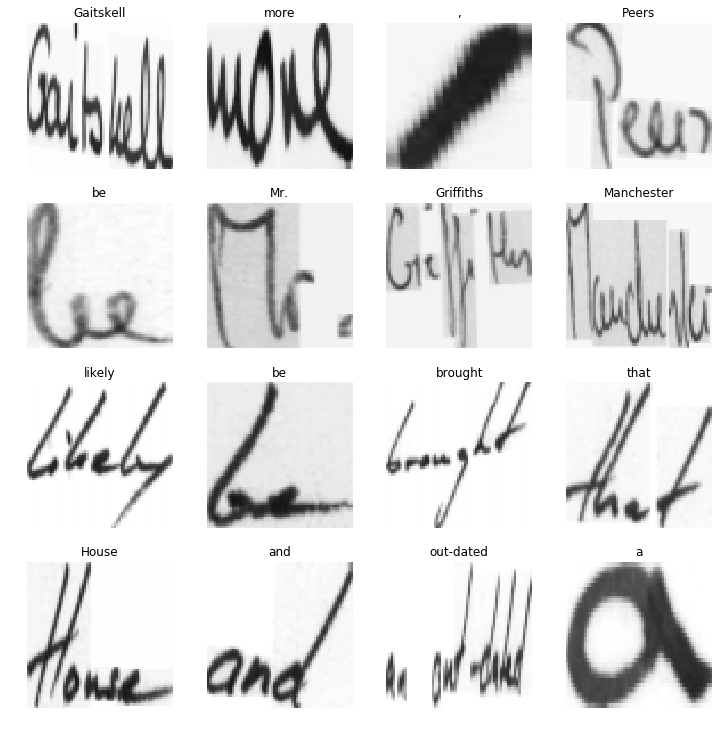

In [61]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    t = data.classes[y[i]]   #=>  words
#     t = label_text(y[i])     #=>  char indices
    ax=show_img(x[i], ax=ax, title=t)
    
plt.tight_layout(pad=0.1)

### Determine size of dataset (300,125)

In [51]:
# create a dictionary comprehension of image sizes in the dataset
size_d = {k: PIL.Image.open(PATH+k).size for k in data.val_ds.fnames}

In [52]:
row_sz,col_sz = list(zip(*size_d.values()))

In [53]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([ 2752.,  3277.,  2014.,  1023.,   406.,   168.,    49.,    18.,     4.,     3.]),
 array([   1. ,   85.1,  169.2,  253.3,  337.4,  421.5,  505.6,  589.7,  673.8,  757.9,  842. ]),
 <a list of 10 Patch objects>)

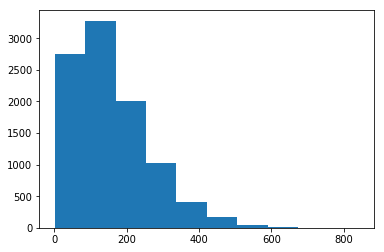

In [54]:
plt.hist(row_sz)

(array([  629.,  1338.,  2883.,  2678.,  1270.,   537.,   262.,    94.,    20.,     3.]),
 array([   1. ,   23.3,   45.6,   67.9,   90.2,  112.5,  134.8,  157.1,  179.4,  201.7,  224. ]),
 <a list of 10 Patch objects>)

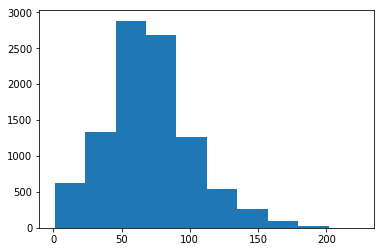

In [55]:
plt.hist(col_sz)

## Simple Word CNN

In [68]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
data = ImageClassifierData.from_csv(PATH, 'words', CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, suffix='.png')

In [69]:
learn = ConvLearner.pretrained(f, data)
learn.opt_fn = optim.Adam

In [ ]:
learn.lr_find()

## Seq2Seq

In [23]:
# def get_block_size(net):
#     return net[-1][-1].bn2.weight.size()[0]

# get_block_size(conv_model)

256

In [15]:
vs = len(itos)
conv_model = nn.Sequential(*children(f(True))[:6])
# (64x64) input:
# [:5] => ([bs, 64, 16, 16]) //4
# [:6] => ([bs, 128, 8, 8])  //8
# [:7] => ([bs, 256, 4, 4])  //16

In [16]:
em_sz,nh,sl = 256,512,20

In [35]:
# based on Show,Attend,Tell - https://github.com/parksunwoo/show_attend_and_tell_pytorch/blob/master/model.py

class Seq2SeqCNN_RNN(nn.Module):
    def __init__(self, conv_model, vs, em_sz, nh, sl, nl=1):
        super().__init__()
        self.nl,self.nh,self.sl = nl,nh,sl   #=> 2, 128, 20
        
        self.pool = nn.AdaptiveMaxPool2d(7)      #(bs,128,7,7)
        self.linear = nn.Linear(128*7*7, em_sz)  #(6272, 256)
        self.bn = nn.BatchNorm1d(em_sz, momentum=0.01)

        self.emb = nn.Embedding(vs, em_sz) #=> Embedding(80, 256)
        self.gru = nn.GRU(em_sz, em_sz, num_layers=nl) #, dropout=0.1)
        self.drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz, vs) #=> ([256, 80])
        
    def forward(self, inp):
        ### Encoder (Conv Layer) ###
        feats = conv_model(inp)        #=> ([50, 128, 16, 16])  (bs,c,h,w)
        feats = self.pool(feats)       #=> ([50, 64, 7, 7])
        feats = feats.view(feats.size(0), -1)   #(bs,6272)
        feats = self.bn(self.linear(feats))     #(bs,256)
        bs,c = feats.size()   # need this because last batch isn't 50

        h = feats.unsqueeze(0)         #(1,bs,256)
    
        ### DECODER LOOP ###    loop through ~20 times -> for each word in output
        dec_inp = V(torch.zeros(bs).long()) #=> ([bs])   # initialize first word and then replace 
        res = []

        for i in range(self.sl):            
            emb = self.emb(dec_inp).unsqueeze(0)         # embedding => ([1, bs, 256])
            outp, h = self.gru(emb, h)                   # rnn => ([1, bs, 256]),  ([1, bs, 256])
            outp = self.out(self.drop(outp[0]))          # dropout, linear layer => ([256, 4085])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])   #=> ([64])
#             if (dec_inp==1).all(): break       # 1: padding token => stop, we're done (padding at the end)
        return torch.stack(res)                  # stack up list of results into single tensor and return it

In [39]:
# categorical cross entropy loss
# list of probabilities for each character in vocab; target is correct character

def seq2seq_loss(input, target):    
    targ = target.transpose(0,1).contiguous()  # need to switch the axes to line up
    sl,bs = targ.size()   #=> ([13,50])
    sl_in,bs_in,nc = input.size()  #=> ([20, 50, 80])
        
    # tweak 1: align sequence lengths (input is always 20 but target often is less)
    if sl_in>sl: targ = F.pad(targ, (0,0,0,sl_in-sl)) # rank2 tensor requires 4 padding values
    # (padLeft, padRight, padTop, padBottom) => (before 1, after 1, before 0, after 0)
    # sequence length: add as much padding as necessary at the end
    
    # input = input[:sl]
    targ = targ[:20,:].long()
    # cross_entropy expects rank2 tensor but we have sl * bs so we need to flatten out both
    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(input.view(-1,nc), targ.view(-1))  #=> ([1000, 80]), ([1000])

In [40]:
rnn = Seq2SeqCNN_RNN(conv_model, vs, em_sz, nh, sl)
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
# SingleModel => way to handle learning rate groups -> treats whole thing as single layer group
# easy way to turn pytorch module into fastai model
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss
learn.clip=10.
# learn.metrics = [accuracy]

In [ ]:
learn.lr_find(start_lr=1e-4)
learn.sched.plot()

In [35]:
lr = 2e-4

## Attention

In [35]:
# based on Show,Attend,Tell - https://github.com/parksunwoo/show_attend_and_tell_pytorch/blob/master/model.py
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))


class Seq2SeqCNN_RNN(nn.Module):
    def __init__(self, conv_model, vs, em_sz, nh, sl, nl=1):
        super().__init__()
        self.nl,self.nh,self.sl = nl,nh,sl   #=> 2, 128, 20
        
        # Encoder
        self.pool = nn.AdaptiveMaxPool2d(7)      #(bs,128,7,7)
        self.linear = nn.Linear(128*7*7, em_sz)  #(6272, 256)
        self.bn = nn.BatchNorm1d(em_sz, momentum=0.01)

        # Decoder
#         self.emb = nn.Embedding(vs, em_sz) #=> Embedding(80, 256)
#         self.attn = nn.Linear(nh, nh)
#         self.gru = nn.GRU(em_sz, nh, num_layers=nl) #, dropout=0.1)
#         self.drop = nn.Dropout(0.35)
#         self.out = nn.Linear(nh, vs) #=> ([256, 80])
      
        self.emb = nn.Embedding(vs, em_sz) #=> Embedding(80, 256)
        self.gru = nn.GRU(em_sz, em_sz, num_layers=nl) #, dropout=0.1)
        self.drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz, vs) #=> ([256, 80])
        
        # setting up Attention Layers
        self.W1 = rand_p(nh, em_sz)  #=> ([512, 256])
        self.l2 = nn.Linear(em_sz, em_sz) 
        self.l3 = nn.Linear(em_sz+nh, em_sz) #=> ([768, 256])
        self.V = rand_p(em_sz)  #=> ([256])
  
        
    def forward(self, inp):
        ### Encoder (Conv Layer) ###
        feats = conv_model(inp)        #=> ([50, 128, 16, 16])  (bs,c,h,w)
        feats = self.pool(feats)       #=> ([50, 128, 7, 7])
        feats = feats.view(feats.size(0), -1)   #(bs,6272)
        feats = self.bn(self.linear(feats))     #(bs,256)
        bs,c = feats.size()   # need this because last batch isn't 50

        h = feats.unsqueeze(0)         #(1,bs,256)
    
        ### DECODER LOOP ###    loop through ~20 times -> for each word in output
        dec_inp = V(torch.zeros(bs).long()) #=> ([bs])   # initialize first word (bos token) and then replace 
        res,attns = [],[]

        # hidden state of the encoder
        w1e = h @ self.W1  #=> ([30, 125, 300])

        for i in range(self.sl):
            # take last hidden state of encoder (current hidden state of decoder) -> linear layer
            #w2h = self.l2(h[-1])  #=> ([125, 300])
            # location aware 7x7 feature map
            w2h = self.l2(torch.)
            
            # non-linear activation
            u = F.tanh(w1e + w2h + w3h + w4h) #=> ([30, 125, 300])
            # matrix multiply; softmax ensures all weights add up to 1 and 1 is higher than the rest
            a = F.softmax(u @ self.V, 0)  #=> ([30, 125])
            attns.append(a)
            Xa = (a.unsqueeze(2) * enc_out).sum(0) #=> ([125, 256])
            emb = self.emb(dec_inp) #=> ([125, 556])
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) #=> ([125, 300])
            
            outp, h = self.gru(wgt_enc.unsqueeze(0), h)

#             emb = self.emb(dec_inp).unsqueeze(0)         # embedding => ([1, bs, 256])
#             outp, h = self.gru(emb, h)                   # rnn => ([1, bs, 256]),  ([1, bs, 256])
            outp = self.out(self.drop(outp[0]))          # dropout, linear layer => ([256, 4085])
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])   #=> ([64])
#             if (dec_inp==1).all(): break       # 1: padding token => stop, we're done (padding at the end)
        return torch.stack(res)                  # stack up list of results into single tensor and return it

    def initHidden(self):
        return V(torch.zeros(self.nl, 1, self.nh, device=device))
    
#     def initHidden(self, bs): return V(torch.zeros(self.nl, bs, em_sz))

### Show, Attend, Tell

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attn = nn.Linear(hidden_size, hidden_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)

    def init_hidden(self):
        return cuda_variable(torch.zeros(self.num_layers, 1, self.hidden_size))

    # decoder_hidden = decoder.init_hidden()
    # outputs = decoder(captions, decoder_hidden, features, lengths)
    def forward(self, captions, last_hidden, encoder_hiddens, lengths):
        # captions: tensor of shape (batch_size, padded_length).
        # lengths: list indicating valid length for each caption. length is (batch_size).
        embeddings = self.embed(captions)
        embeddings = torch.cat((last_hidden.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        rnn_output = self.linear(hiddens[0])
        print (rnn_output)

        attn_weights = self._get_att_weight(rnn_output.squeeze(0), encoder_hiddens)
        context = attn_weights.bmm(encoder_hiddens.transpose(0,1))

        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        output = self.out(torch.cat((rnn_output, context), 1))

        return output

    def _get_att_weight(self, hidden, encoder_hiddens):
        seq_len = len(encoder_hiddens)

        # Create variable to store attention energies
        attn_scores = cuda_variable(torch.zeros(seq_len))  # B x 1 x S

        # Calculate energies for each encoder hidden
        for i in range(seq_len):
            attn_scores[i] = self.get_att_score(hidden, encoder_hiddens[i])

        # Normalize scores to weights in range 0 to 1,
        # resize to 1 x 1 x seq_len
        # print("att_scores", attn_scores.size())
        return nn.softmax(attn_scores).view(1, 1, -1)


    def get_att_score(self, hidden, encoder_hidden):
        score = self.attn(encoder_hidden)
        return torch.dot(hidden.view(-1), score.view(-1))

### Pytorch tutorial - seq2seq w/ attention

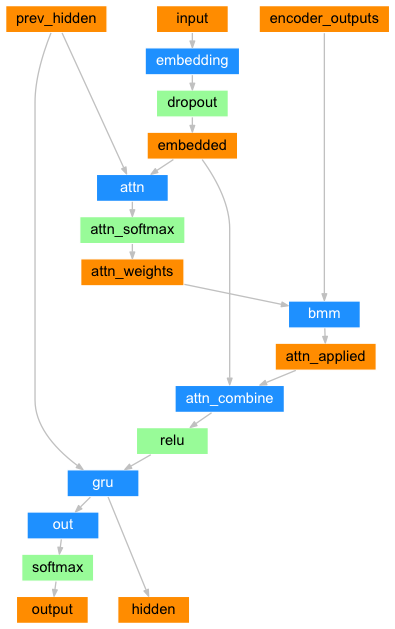

In [ ]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#attention-decoder

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        # 256, ,10
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size  # 256
        self.output_size = output_size  # num words in output ~ vs
        self.dropout_p = dropout_p
        self.max_length = max_length    # 10

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        # decoder_input = torch.tensor([[SOS_token]], device=device)  # BOS token
        # decoder_hidden = encoder_hidden
        # encoder_outputs = ([input_length, max_length, hidden_size])
        
        
        ### Encoder (Conv Layer) ###
        feats = conv_model(inp)              #=> ([50, 128, 16, 16])  (bs,c,h,w)
        feats = self.pool(feats)             #=> ([50, 64, 7, 7])
        out = feats.view(feats.size(0), -1)  #(bs,6272)
        out = self.bn(self.linear(out))      #(bs,256)
        bs,c = out.size()                    # need this because last batch isn't 50
        h = out.unsqueeze(0)                 #(1,bs,256)
 
        
        
        # Embed the input & apply dropout
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        # Concatenate embedded input & hidden -> linear layer -> softmax
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        
        # Batch Matrix Multiply attention weights and encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        # Concatenate applied attention & embedded input -> linear layer -> relu
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

### From Translation notebook

In [ ]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Seq2SeqAttnRNN(nn.Module):
    def __init__(self, vecs_enc, itos_enc, em_sz_enc, vecs_dec, itos_dec, em_sz_dec, nh, out_sl, nl=2):
        super().__init__()
        self.emb_enc = create_emb(vecs_enc, itos_enc, em_sz_enc)
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        self.emb_dec = create_emb(vecs_dec, itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data

        # setting up Attention Layers
        self.W1 = rand_p(nh, em_sz_dec)  #=> ([256, 300])
        self.l2 = nn.Linear(em_sz_dec, em_sz_dec) 
        self.l3 = nn.Linear(em_sz_dec+nh, em_sz_dec) #=> ([556, 300])
        self.V = rand_p(em_sz_dec)  #=> ([300])

    def forward(self, inp, y=None, ret_attn=False):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)  #=> ([30, 125, 256]), ([2, 125, 256])
        # enc_out: final output of encoder layer (shape depends on input size!!)
        # h: final state of cell
        h = self.out_enc(h)

        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        # matrix multiply; hidden state at each time step and a random (learnable) matrix        
        w1e = enc_out @ self.W1  #=> ([30, 125, 300])
        
        for i in range(self.out_sl):
            # take last hidden state of encoder (current hidden state of decoder) -> linear layer
            w2h = self.l2(h[-1])  #=> ([125, 300])
            # non-linear activation
            u = F.tanh(w1e + w2h) #=> ([30, 125, 300])
            # matrix multiply; softmax ensures all weights add up to 1 and 1 is higher than the rest
            a = F.softmax(u @ self.V, 0)  #=> ([30, 125])
            attns.append(a)
            # a.unsqueeze(2): add axis at index 2 => ([30, 125, 1])
            # weighted sum of all of the encoder outputs w/ attention results
            Xa = (a.unsqueeze(2) * enc_out).sum(0) #=> ([125, 256])
            emb = self.emb_dec(dec_inp)
                                #=> ([125, 556])
            wgt_enc = self.l3(torch.cat([emb, Xa], 1)) #=> ([125, 300])
            
            outp, h = self.gru_dec(wgt_enc.unsqueeze(0), h)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = V(outp.data.max(1)[1])
            if (dec_inp==1).all(): break
            if (y is not None) and (random.random()<self.pr_force):
                if i>=len(y): break
                dec_inp = y[i]

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [26]:
rnn = Seq2SeqCNN_RNN(conv_model, vs, em_sz, nh, sl)
# SingleModel => way to handle learning rate groups -> treats whole thing as single group
# easy way to turn pytorch module into fastai model
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.crit = seq2seq_loss
learn.clip=10.
# learn.metrics = [accuracy]

In [ ]:
learn.lr_find(start_lr=1e-4)
learn.sched.plot()